In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [49]:
categories = pd.read_csv('../result/category.csv')['category'].values
category = categories[3]

In [50]:
df = pd.read_csv('../result/data_modeling.csv')
df = df[df['category'] == category]
df = df.drop('category', axis=1)

df['date'] = pd.to_datetime(df['date'])

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 1073 to 1438
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   366 non-null    datetime64[ns]
 1   hits_sum                               366 non-null    int64         
 2   hits_mean                              366 non-null    float64       
 3   visits_sum                             366 non-null    int64         
 4   visits_mean                            366 non-null    float64       
 5   page_views_sum                         366 non-null    int64         
 6   page_views_mean                        366 non-null    float64       
 7   first_visits_sum                       366 non-null    int64         
 8   first_visits_mean                      366 non-null    float64       
 9   time_on_site_sum                       366 non-null    int64 

,date,hits_sum,hits_mean,visits_sum,visits_mean,page_views_sum,page_views_mean,first_visits_sum,first_visits_mean,time_on_site_sum,...,transactions_sum,medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral,action_Check out,action_Click through of product lists,action_Completed purchase,action_Product detail views
1073,2016-08-01,18143,54.320359,334,1.0,11735,35.134731,163,0.488024,271330,...,18,0,39,10,48,9,0,186,0,148
1074,2016-08-02,15340,47.639752,322,1.0,10386,32.254658,136,0.422360,330006,...,28,0,23,2,145,10,0,176,0,146
1075,2016-08-03,24630,64.140625,384,1.0,16447,42.830729,185,0.481771,444573,...,0,0,14,0,152,12,0,204,0,180
1076,2016-08-04,17625,53.247734,331,1.0,11758,35.522659,134,0.404834,351495,...,16,3,2,0,102,8,0,186,0,145
1077,2016-08-05,25145,73.095930,344,1.0,18238,53.017442,194,0.563953,569107,...,92,0,67,0,146,8,0,189,0,155


In [51]:
# Time splitting 
n_days = 90
max_date = df['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

train = df[df['date'] <= cutoff]
test = df[df['date'] > cutoff]

test = test.set_index('date')
train = train.set_index('date')

In [52]:
# Preparation
test_target = test[['transactions_sum']]
test_fields = test.drop(['transactions_sum'], axis=1)


train_target = train[['transactions_sum']]
train_fields = train.drop(['transactions_sum'], axis=1)

In [53]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV

# xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=123)

# model = GridSearchCV(estimator=xgb_reg, 
#                              param_grid=dict(learning_rate=[0.01, 0.1, 0.3, 0.5]),
#                              scoring='neg_mean_absolute_error',
#                              refit=True,
#                              cv=5)

# model.fit(train_fields, train_target)

In [54]:
# print("Best score: ", model.best_score_)
# print("Best params: ", model.best_params_)
# print("Best estimator: \n", model.best_estimator_)

In [55]:
# imp_feat_reg = model\
#                 .best_estimator_\
#                 .get_booster()\
#                 .get_score(importance_type='gain')

# pd.DataFrame.from_dict(imp_feat_reg, orient='index').plot(kind='bar')
# plt.show()

In [56]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(train_fields, train_target.values.reshape(-1, ))

RandomForestRegressor(random_state=42)

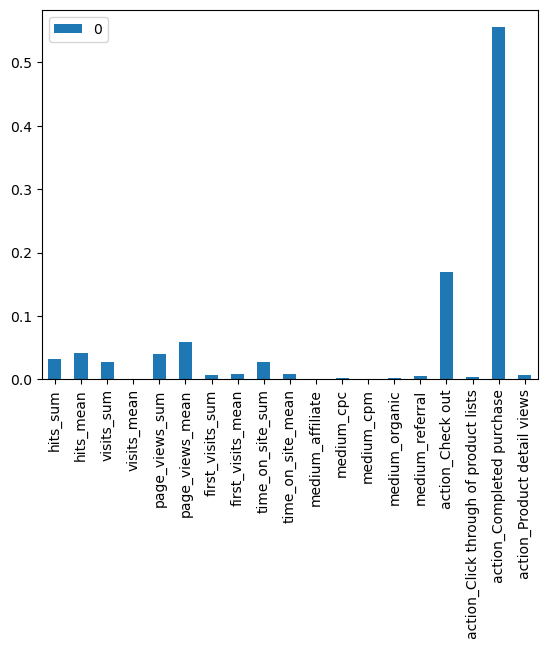

In [57]:
imp_feat_reg = model.feature_importances_

pd.DataFrame(imp_feat_reg.reshape(1, -1), columns=train_fields.columns).T.plot(kind='bar')
plt.show()

In [75]:
from sklearn.metrics import mean_squared_error

predictions_reg = model.predict(test_fields)
predictions_reg = pd.DataFrame(predictions_reg, index=test.index, columns=['transactions_pred'])

# Calculate performance metrics
mse = mean_squared_error(test_target, predictions_reg)
print(f"Mean Squared Error: {mse}")

df_pred = pd.merge(test_target.iloc[:-1], predictions_reg, left_index=True, right_index=True)
df_pred

Mean Squared Error: 553.7536266666668


,transactions_sum,transactions_pred
date,,
2017-05-04,43,50.97
2017-05-05,142,125.62
2017-05-06,29,52.21
2017-05-07,113,83.79
2017-05-08,107,117.59
...,...,...
2017-07-27,225,225.64
2017-07-28,205,133.54
2017-07-29,47,54.98


In [76]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = px.line(df_pred.resample('M').mean(), labels={'value': 'Total Transactions',
                                                    'transcations_sum': 'Transactions (Actual)',
                                                    'pred_transactions': 'Transactions {Prediction}'})
fig.show()

In [77]:
# Prediction next month value
combined_fields = pd.concat([train_fields, test_fields])
predictions_all = model.predict(combined_fields)
predictions_all = pd.DataFrame(predictions_all, index=combined_fields.index, columns=['transactions_pred'])

pred_08 = predictions_all.resample('M').mean().values.mean()
temp_frame = pd.DataFrame(index=pd.date_range(start='2017-08-01', end='2017-08-31'))
temp_frame.index.name = 'date'
temp_frame['transactions_pred'] = pred_08

In [78]:
df_result = pd.concat([df_pred, temp_frame]).reset_index().copy()
df_result['category'] = [category] * df_result.shape[0]
# df_result['transactions_sum'] = df_result['transactions_sum'].astype('int64')
df_result['transactions_pred'] = df_result['transactions_pred'].astype('int64')

df_result.to_csv(f'../result/prediction-revenue-{category}.csv', index=False)